# Rolling Window Analysis: Expanding Time Windows (No Data Leakage)

This notebook analyzes how model performance changes as we incrementally expand the analysis window from PRE-decision into POST-decision period.

**Critical: No Data Leakage**
- Each window extracts features from a **continuously expanding time range**
- Window 1: -2.0 to 0.0s (PRE baseline)
- Window 2: -2.0 to 0.2s (includes PRE + first 0.2s POST)
- Window 3: -2.0 to 0.4s (includes PRE + first 0.4s POST)
- etc.

**Analysis Strategy:**
1. For each window, dynamically extract ALL features from the full time range
2. Train fusion model on features from that specific window
3. Visualize how performance evolves as we gain more temporal information

In [5]:
import sys
sys.path.append('../..')

import numpy as np
import pandas as pd
from pathlib import Path
import pickle
import json
import re
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Import project utilities
from src.utils.io import save_results
from src.utils.config import get_model_params
from src.models.fusion import weighted_late_fusion
from src.visualization.plots import set_style

np.random.seed(42)
set_style('whitegrid')

print(f"\n{'='*80}")
print(f"ROLLING WINDOW ANALYSIS (DYNAMIC): PRE → POST DECISION PERIOD")
print(f"{'='*80}\n")
print(f"Analysis started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")


ROLLING WINDOW ANALYSIS (DYNAMIC): PRE → POST DECISION PERIOD

Analysis started: 2026-01-11 13:21:52


## 1. Define Rolling Windows

In [6]:
# Define rolling window endpoints
PRE_START = -2.0
PRE_END = 0.0
POST_STEP = 0.2  # Increment size for POST expansion
POST_MAX = 2.0   # Maximum POST time

# Generate windows - each window is a SINGLE continuous time range
windows = []

# Window 1: PRE only (baseline)
windows.append({
    'name': 'PRE Only',
    'time_range': (PRE_START, PRE_END),
    'description': 'Baseline: -2.0 to 0.0s (PRE only)'
})

# Windows 2+: Expanding into POST
post_endpoints = np.arange(POST_STEP, POST_MAX + POST_STEP, POST_STEP)
for post_end in post_endpoints:
    windows.append({
        'name': f'Expanded[→{post_end:.1f}s]',
        'time_range': (PRE_START, post_end),
        'description': f'Continuous: -2.0 to {post_end:.1f}s'
    })

print(f"Created {len(windows)} rolling windows:")
print("\nWindow Details:")
print("-" * 80)
for i, w in enumerate(windows):
    duration = w['time_range'][1] - w['time_range'][0]
    print(f"{i+1:2d}. {w['name']:25s} | {w['description']:40s} | Duration: {duration:.1f}s")
print("-" * 80)

Created 11 rolling windows:

Window Details:
--------------------------------------------------------------------------------
 1. PRE Only                  | Baseline: -2.0 to 0.0s (PRE only)        | Duration: 2.0s
 2. Expanded[→0.2s]           | Continuous: -2.0 to 0.2s                 | Duration: 2.2s
 3. Expanded[→0.4s]           | Continuous: -2.0 to 0.4s                 | Duration: 2.4s
 4. Expanded[→0.6s]           | Continuous: -2.0 to 0.6s                 | Duration: 2.6s
 5. Expanded[→0.8s]           | Continuous: -2.0 to 0.8s                 | Duration: 2.8s
 6. Expanded[→1.0s]           | Continuous: -2.0 to 1.0s                 | Duration: 3.0s
 7. Expanded[→1.2s]           | Continuous: -2.0 to 1.2s                 | Duration: 3.2s
 8. Expanded[→1.4s]           | Continuous: -2.0 to 1.4s                 | Duration: 3.4s
 9. Expanded[→1.6s]           | Continuous: -2.0 to 1.6s                 | Duration: 3.6s
10. Expanded[→1.8s]           | Continuous: -2.0 to 1.8s        

## 2. Load PRE Features

PRE features are pre-extracted and loaded once.

In [7]:
print("Loading PRE-decision features...")
with open('../../data/results/features_PRE/extracted_features_PRE.pkl', 'rb') as f:
    pre_data = pickle.load(f)

pre_df = pre_data['merged_df']
pre_physio_cols = pre_data['physio_cols']
pre_behavior_cols = pre_data['behavior_cols']
pre_gaze_cols = pre_data['gaze_cols']

print(f"  PRE trials: {len(pre_df)}")
print(f"  PRE subjects: {pre_df['subject_id'].nunique()}")
print(f"  PRE features: {len(pre_physio_cols)} physio + {len(pre_behavior_cols)} behavior + {len(pre_gaze_cols)} gaze")
print(f"\n✓ PRE features loaded")

Loading PRE-decision features...
  PRE trials: 12511
  PRE subjects: 97
  PRE features: 13 physio + 7 behavior + 20 gaze

✓ PRE features loaded


## 3. Define Feature Extraction for Expanding Windows

Extract features for a continuous time window (no separate PRE/POST).

In [8]:
def extract_features_for_window(time_window, baseline_method='t3_stable_pre_decision'):
    """
    Extract ALL features (physiology, behavior, gaze) for a continuous time window.
    
    NO DATA LEAKAGE: Only uses data from start to end of the specified window.
    
    Parameters
    ----------
    time_window : tuple
        (start, end) in seconds relative to submit (e.g., (-2.0, 0.2))
    baseline_method : str
        Baseline correction method name
    
    Returns
    -------
    pd.DataFrame
        DataFrame with trial_id, subject_id, outcome, and ALL features from the window
    """
    preprocessing_dir = Path('../../data/results/preprocessing_outputs/preprocessing')
    preprocessing_files = sorted(preprocessing_dir.glob('preprocessing_*.json'))
    raw_dir = Path('../../data/raw/json')
    
    all_features = []
    
    for preprocessed_file in preprocessing_files:
        with open(preprocessed_file, 'r') as f:
            preprocessed = json.load(f)
        
        subject_id = preprocessed['subject_id']
        
        # Find matching raw JSON
        matches = list(raw_dir.glob(f"*{subject_id.split('_')[-1]}.json"))
        pattern = subject_id.replace("_", ".*")
        match = next((f for f in matches if re.search(pattern, f.name)), None)
        if not match:
            continue
        
        with open(match, 'r') as f:
            raw_data = json.load(f)
        
        for trial_id, trial_data in preprocessed['trial_data'].items():
            method_data = trial_data['methods'][baseline_method]
            
            if method_data['success'] != True:
                continue
            
            raw_trial = raw_data['trials'][int(trial_id)-1]
            if not raw_trial['gamble details']['submitted']:
                continue
            
            # === PHYSIOLOGY FEATURES ===
            time_aligned = np.array(trial_data['time_relative_to_submit'])
            pupil_avg = np.array(method_data['pupil_avg_baselined'])
            pupil_L = np.array(method_data['pupil_L_baselined'])
            pupil_R = np.array(method_data['pupil_R_baselined'])
            
            # Clean NaN values
            valid_mask = ~np.isnan(pupil_avg)
            pupil_avg_clean = pupil_avg[valid_mask]
            pupil_L_clean = pupil_L[valid_mask]
            pupil_R_clean = pupil_R[valid_mask]
            time_clean = time_aligned[valid_mask]
            
            if len(pupil_avg_clean) < 20:
                continue
            
            # Filter to FULL CONTINUOUS window (no data leakage!)
            time_mask = (time_clean >= time_window[0]) & (time_clean <= time_window[1])
            pupil = pupil_avg_clean[time_mask]
            pupil_L_filtered = pupil_L_clean[time_mask]
            pupil_R_filtered = pupil_R_clean[time_mask]
            time_filtered = time_clean[time_mask]
            
            if len(pupil) < 5:
                continue
            
            # Calculate derivatives
            pupil_velocity = np.diff(pupil) if len(pupil) > 1 else np.array([0])
            pupil_acceleration = np.diff(pupil_velocity) if len(pupil_velocity) > 1 else np.array([0])
            dilation_mask = pupil_velocity > 0 if len(pupil_velocity) > 0 else np.array([False])
            
            # Extract physiology features
            features = {
                'trial_id': f"{trial_id}_{subject_id}",
                'subject_id': subject_id,
                # Physiology
                'pupil_mean': np.mean(pupil),
                'pupil_std': np.std(pupil),
                'pupil_slope': np.polyfit(time_filtered, pupil, 1)[0] if len(time_filtered) > 1 else 0,
                'time_to_peak': time_filtered[np.argmax(pupil)] - time_filtered[0] if len(time_filtered) > 0 else 0,
                'pupil_cv': np.std(pupil) / np.abs(np.mean(pupil)) if (len(pupil) > 0 and np.mean(pupil) != 0) else 0,
                'pupil_velocity_mean': np.mean(np.abs(pupil_velocity)) if len(pupil_velocity) > 0 else 0,
                'pupil_max_dilation_rate': np.max(pupil_velocity) if len(pupil_velocity) > 0 else 0,
                'pupil_max_constriction_rate': np.abs(np.min(pupil_velocity)) if len(pupil_velocity) > 0 else 0,
                'pupil_acceleration_std': np.std(pupil_acceleration) if len(pupil_acceleration) > 1 else 0,
                'pct_time_dilating': np.mean(dilation_mask) if len(dilation_mask) > 0 else 0,
                'num_dilation_peaks': np.sum(np.diff(np.sign(pupil_velocity)) > 0) if len(pupil_velocity) > 1 else 0,
                'eye_asymmetry': np.nanmean(np.abs(pupil_L_filtered - pupil_R_filtered)) if len(pupil_L_filtered) > 0 else 0,
                'eye_asymmetry_std': np.nanstd(pupil_L_filtered - pupil_R_filtered) if len(pupil_L_filtered) > 1 else 0,
            }
            
            # === BEHAVIOR FEATURES (decision-time metrics) ===
            gamble_params = raw_trial['gamble details']['gamble parameters']
            lct = raw_trial['lct']
            
            show_screen_time = None
            submit_time = None
            click_time = None
            
            for event in lct:
                if 'show screen' in event['event']:
                    show_screen_time = event['time']
                elif 'gamble clicked' in event['event']:
                    click_time = event['time']
                elif 'submit' in event['event']:
                    submit_time = event['time']
            
            if show_screen_time is None or submit_time is None:
                continue
            
            reaction_time = (click_time - show_screen_time) if click_time else np.nan
            decision_time = (submit_time - show_screen_time)
            
            invest_ev = (gamble_params['invest amount 1'] * gamble_params['invest probability 1'] + 
                        gamble_params['invest amount 2'] * gamble_params['invest probability 2'])
            keep_ev = gamble_params['keep amount']
            ev_difference = invest_ev - keep_ev
            
            invest_variance = ((gamble_params['invest amount 1'] - invest_ev)**2 * gamble_params['invest probability 1'] +
                            (gamble_params['invest amount 2'] - invest_ev)**2 * gamble_params['invest probability 2'])
            
            final_choice = raw_trial['gamble details']['choices'][-1]['choice'] if len(raw_trial['gamble details']['choices']) > 0 else None
            chose_invest = 1 if final_choice == 'INVEST' else 0
            
            features.update({
                'reaction_time': reaction_time if not np.isnan(reaction_time) else decision_time,
                'decision_time': decision_time,
                'ev_difference': ev_difference,
                'invest_variance': invest_variance,
                'ambiguity': gamble_params['ambiguity'],
                'condition_social': 1 if gamble_params['condition'] == 'social' else 0,
                'risk_premium': ev_difference / np.sqrt(invest_variance) if invest_variance > 0 else 0,
                'outcome': chose_invest,
            })
            
            # === GAZE FEATURES (from continuous window) ===
            eye_data = raw_trial.get('eye', [])
            if len(eye_data) > 0 and submit_time is not None:
                # Filter eye data to the SAME continuous window
                eye_times = np.array([s['time'] for s in eye_data])
                eye_relative = (eye_times - submit_time) / 1000.0  # Convert to seconds
                eye_mask = (eye_relative >= time_window[0]) & (eye_relative <= time_window[1])
                
                if eye_mask.sum() >= 5:
                    filtered_eye = [eye_data[i] for i in np.where(eye_mask)[0]]
                    
                    # Extract gaze coordinates
                    gaze_x_L = np.array([s.get('gazeL_X', np.nan) for s in filtered_eye])
                    gaze_y_L = np.array([s.get('gazeL_Y', np.nan) for s in filtered_eye])
                    gaze_x_R = np.array([s.get('gazeR_X', np.nan) for s in filtered_eye])
                    gaze_y_R = np.array([s.get('gazeR_Y', np.nan) for s in filtered_eye])
                    
                    gaze_x = np.nanmean([gaze_x_L, gaze_x_R], axis=0)
                    gaze_y = np.nanmean([gaze_y_L, gaze_y_R], axis=0)
                    
                    screen_x_L = np.array([s.get('pupilLSensorPosL_X', np.nan) for s in filtered_eye])
                    screen_y_L = np.array([s.get('pupilLSensorPosL_Y', np.nan) for s in filtered_eye])
                    screen_x_R = np.array([s.get('pupilLSensorPosR_X', np.nan) for s in filtered_eye])
                    screen_y_R = np.array([s.get('pupilLSensorPosR_Y', np.nan) for s in filtered_eye])
                    
                    screen_x = np.nanmean([screen_x_L, screen_x_R], axis=0)
                    screen_y = np.nanmean([screen_y_L, screen_y_R], axis=0)
                    
                    valid_L = np.array([s.get('validL', 0) for s in filtered_eye])
                    valid_R = np.array([s.get('validR', 0) for s in filtered_eye])
                    valid_mask_gaze = (valid_L > 0) & (valid_R > 0)
                    
                    if valid_mask_gaze.sum() >= 5:
                        gaze_x_valid = gaze_x[valid_mask_gaze]
                        gaze_y_valid = gaze_y[valid_mask_gaze]
                        screen_x_valid = screen_x[valid_mask_gaze]
                        screen_y_valid = screen_y[valid_mask_gaze]
                        timestamps_valid = np.array([filtered_eye[i]['time'] for i in np.where(valid_mask_gaze)[0]])
                        
                        # Calculate gaze features
                        dt = np.diff(timestamps_valid)
                        dt[dt == 0] = 1e-6
                        dx = np.diff(screen_x_valid)
                        dy = np.diff(screen_y_valid)
                        velocity = np.sqrt(dx**2 + dy**2) / dt
                        
                        features.update({
                            'gaze_valid_pct': np.mean(valid_mask_gaze),
                            'gaze_x_mean': np.nanmean(gaze_x_valid),
                            'gaze_x_std': np.nanstd(gaze_x_valid),
                            'gaze_y_mean': np.nanmean(gaze_y_valid),
                            'gaze_y_std': np.nanstd(gaze_y_valid),
                            'screen_x_mean': np.nanmean(screen_x_valid),
                            'screen_x_std': np.nanstd(screen_x_valid),
                            'screen_y_mean': np.nanmean(screen_y_valid),
                            'screen_y_std': np.nanstd(screen_y_valid),
                            'gaze_velocity_mean': np.nanmean(velocity),
                            'gaze_velocity_std': np.nanstd(velocity),
                            'gaze_velocity_max': np.nanmax(velocity),
                            'gaze_acceleration_mean': np.nanmean(np.abs(np.diff(velocity) / dt[:-1])) if len(velocity) > 1 else 0,
                            'gaze_acceleration_std': np.nanstd(np.diff(velocity) / dt[:-1]) if len(velocity) > 1 else 0,
                            'fixation_ratio': np.mean(velocity < 30),
                            'saccade_ratio': np.mean(velocity > 100),
                            'saccade_count': np.sum(np.diff((velocity > 100).astype(int)) == 1),
                            'gaze_dispersion_x': np.nanmax(screen_x_valid) - np.nanmin(screen_x_valid),
                            'gaze_dispersion_y': np.nanmax(screen_y_valid) - np.nanmin(screen_y_valid),
                            'gaze_path_length': np.sum(np.sqrt(dx**2 + dy**2)),
                        })
            
            all_features.append(features)
    
    return pd.DataFrame(all_features)

print("✓ Feature extraction function defined (continuous windows, no data leakage)")

✓ Feature extraction function defined (continuous windows, no data leakage)


## 4. Run Rolling Window Analysis

For each window, extract POST features dynamically and train the model.

In [9]:
rolling_results = []

print(f"\n{'='*80}")
print("RUNNING ROLLING WINDOW ANALYSIS (CONTINUOUS WINDOWS - NO DATA LEAKAGE)")
print(f"{'='*80}\n")

for i, window in enumerate(windows):
    print(f"\nWindow {i+1}/{len(windows)}: {window['name']}")
    print(f"  {window['description']}")
    print("-" * 80)
    
    # Extract features for THIS continuous window only
    print(f"  Extracting ALL features from {window['time_range'][0]} to {window['time_range'][1]}s...")
    window_df = extract_features_for_window(window['time_range'])
    print(f"    Extracted {len(window_df)} trials")
    
    if len(window_df) == 0:
        print(f"  ✗ No trials extracted, skipping...")
        continue
    
    # Separate modalities
    physio_cols = [c for c in window_df.columns if c in [
        'pupil_mean', 'pupil_std', 'pupil_slope', 'time_to_peak', 'pupil_cv',
        'pupil_velocity_mean', 'pupil_max_dilation_rate', 'pupil_max_constriction_rate',
        'pupil_acceleration_std', 'pct_time_dilating', 'num_dilation_peaks',
        'eye_asymmetry', 'eye_asymmetry_std'
    ]]
    
    behavior_cols = [c for c in window_df.columns if c in [
        'reaction_time', 'decision_time', 'ev_difference', 'invest_variance',
        'ambiguity', 'condition_social', 'risk_premium'
    ]]
    
    gaze_cols = [c for c in window_df.columns if c.startswith(('gaze_', 'screen_')) or c in [
        'fixation_ratio', 'saccade_ratio', 'saccade_count'
    ]]
    
    print(f"  Feature counts: Physio={len(physio_cols)}, Behavior={len(behavior_cols)}, Gaze={len(gaze_cols)}")
    
    # Prepare arrays
    X_physio = SimpleImputer(strategy='mean').fit_transform(window_df[physio_cols]) if len(physio_cols) > 0 else np.zeros((len(window_df), 1))
    X_behavior = SimpleImputer(strategy='mean').fit_transform(window_df[behavior_cols]) if len(behavior_cols) > 0 else np.zeros((len(window_df), 1))
    X_gaze = SimpleImputer(strategy='mean').fit_transform(window_df[gaze_cols]) if len(gaze_cols) > 0 else np.zeros((len(window_df), 1))
    
    y = window_df['outcome'].values
    subjects = window_df['subject_id'].values
    
    print(f"  Final shapes: Physio={X_physio.shape}, Behavior={X_behavior.shape}, Gaze={X_gaze.shape}")
    
    # Run weighted late fusion
    X_modalities = [X_physio, X_behavior, X_gaze]
    modality_names = ['Physiology', 'Behavior', 'Gaze']
    
    try:
        results = weighted_late_fusion(
            X_modalities, y, subjects, modality_names,
            fusion_method='weighted'
        )
        
        window_result = {
            'window_id': i,
            'window_name': window['name'],
            'time_start': window['time_range'][0],
            'time_end': window['time_range'][1],
            'duration': window['time_range'][1] - window['time_range'][0],
            'accuracy': results['accuracy_mean'],
            'accuracy_sem': results['accuracy_sem'],
            'accuracy_std': results['accuracy_std'],
            'f1_score': results['f1_mean'],
            'f1_sem': results['f1_sem'],
            'physio_weight': results['weights'][0],
            'behavior_weight': results['weights'][1],
            'gaze_weight': results['weights'][2],
            'n_subjects': results['n_subjects'],
            'n_trials': results['n_trials'],
            'n_physio_features': X_physio.shape[1],
            'n_behavior_features': X_behavior.shape[1],
            'n_gaze_features': X_gaze.shape[1],
            'invest_ratio': np.mean(y)
        }
        
        rolling_results.append(window_result)
        
        print(f"  ✓ Accuracy: {results['accuracy_mean']:.4f} ± {results['accuracy_sem']:.4f}")
        print(f"    F1-Score: {results['f1_mean']:.4f} ± {results['f1_sem']:.4f}")
        print(f"    Weights: Physio={results['weights'][0]:.3f}, Behavior={results['weights'][1]:.3f}, Gaze={results['weights'][2]:.3f}")
        
    except Exception as e:
        print(f"  ✗ Error: {e}")
        import traceback
        traceback.print_exc()
        continue

results_df = pd.DataFrame(rolling_results)

print(f"\n{'='*80}")
print(f"✓ Analysis complete: {len(results_df)} windows analyzed")
print(f"{'='*80}")


RUNNING ROLLING WINDOW ANALYSIS (CONTINUOUS WINDOWS - NO DATA LEAKAGE)


Window 1/11: PRE Only
  Baseline: -2.0 to 0.0s (PRE only)
--------------------------------------------------------------------------------
  Extracting ALL features from -2.0 to 0.0s...
    Extracted 11467 trials
  Feature counts: Physio=13, Behavior=7, Gaze=20
  Final shapes: Physio=(11467, 13), Behavior=(11467, 7), Gaze=(11467, 20)
  ✓ Accuracy: 0.7227 ± 0.0140
    F1-Score: 0.7093 ± 0.0162
    Weights: Physio=0.016, Behavior=0.512, Gaze=0.472

Window 2/11: Expanded[→0.2s]
  Continuous: -2.0 to 0.2s
--------------------------------------------------------------------------------
  Extracting ALL features from -2.0 to 0.2s...
    Extracted 11467 trials
  Feature counts: Physio=13, Behavior=7, Gaze=20
  Final shapes: Physio=(11467, 13), Behavior=(11467, 7), Gaze=(11467, 20)
  ✓ Accuracy: 0.7230 ± 0.0141
    F1-Score: 0.7095 ± 0.0163
    Weights: Physio=0.015, Behavior=0.512, Gaze=0.473

Window 3/11: Expanded[→0.4

## 5. Visualize Results

In [11]:
results_df

,window_id,window_name,time_start,time_end,duration,accuracy,accuracy_sem,accuracy_std,f1_score,f1_sem,physio_weight,behavior_weight,gaze_weight,n_subjects,n_trials,n_physio_features,n_behavior_features,n_gaze_features,invest_ratio
0,0,PRE Only,-2.0,0.0,2.0,0.722717,0.014034,0.137502,0.709270,0.016244,0.016134,0.511675,0.472191,97,11467,13,7,20,0.658411
1,1,Expanded[→0.2s],-2.0,0.2,2.2,0.722981,0.014113,0.138279,0.709512,0.016304,0.014897,0.512383,0.472720,97,11467,13,7,20,0.658411
2,2,Expanded[→0.4s],-2.0,0.4,2.4,0.722332,0.014084,0.137998,0.708773,0.016268,0.012283,0.514044,0.473673,97,11467,13,7,20,0.658411
3,3,Expanded[→0.6s],-2.0,0.6,2.6,0.721711,0.014075,0.137907,0.708205,0.016273,0.012665,0.514364,0.472970,97,11467,13,7,20,0.658411
4,4,Expanded[→0.8s],-2.0,0.8,2.8,0.722682,0.014166,0.138802,0.709025,0.016380,0.015097,0.512166,0.472737,97,11467,13,7,20,0.658411
5,5,Expanded[→1.0s],-2.0,1.0,3.0,0.723030,0.014142,0.138563,0.709580,0.016354,0.015111,0.512310,0.472579,97,11467,13,7,20,0.658411
6,6,Expanded[→1.2s],-2.0,1.2,3.2,0.722383,0.014105,0.138195,0.708864,0.016304,0.014156,0.512805,0.473039,97,11467,13,7,20,0.658411
7,7,Expanded[→1.4s],-2.0,1.4,3.4,0.722161,0.014067,0.137832,0.708658,0.016273,0.012905,0.513124,0.473970,97,11467,13,7,20,0.658411
8,8,Expanded[→1.6s],-2.0,1.6,3.6,0.722084,0.014036,0.137527,0.708893,0.016209,0.012512,0.512986,0.474501,97,11467,13,7,20,0.658411
9,9,Expanded[→1.8s],-2.0,1.8,3.8,0.721124,0.014047,0.137629,0.707915,0.016219,0.011554,0.513291,0.475155,97,11467,13,7,20,0.658411


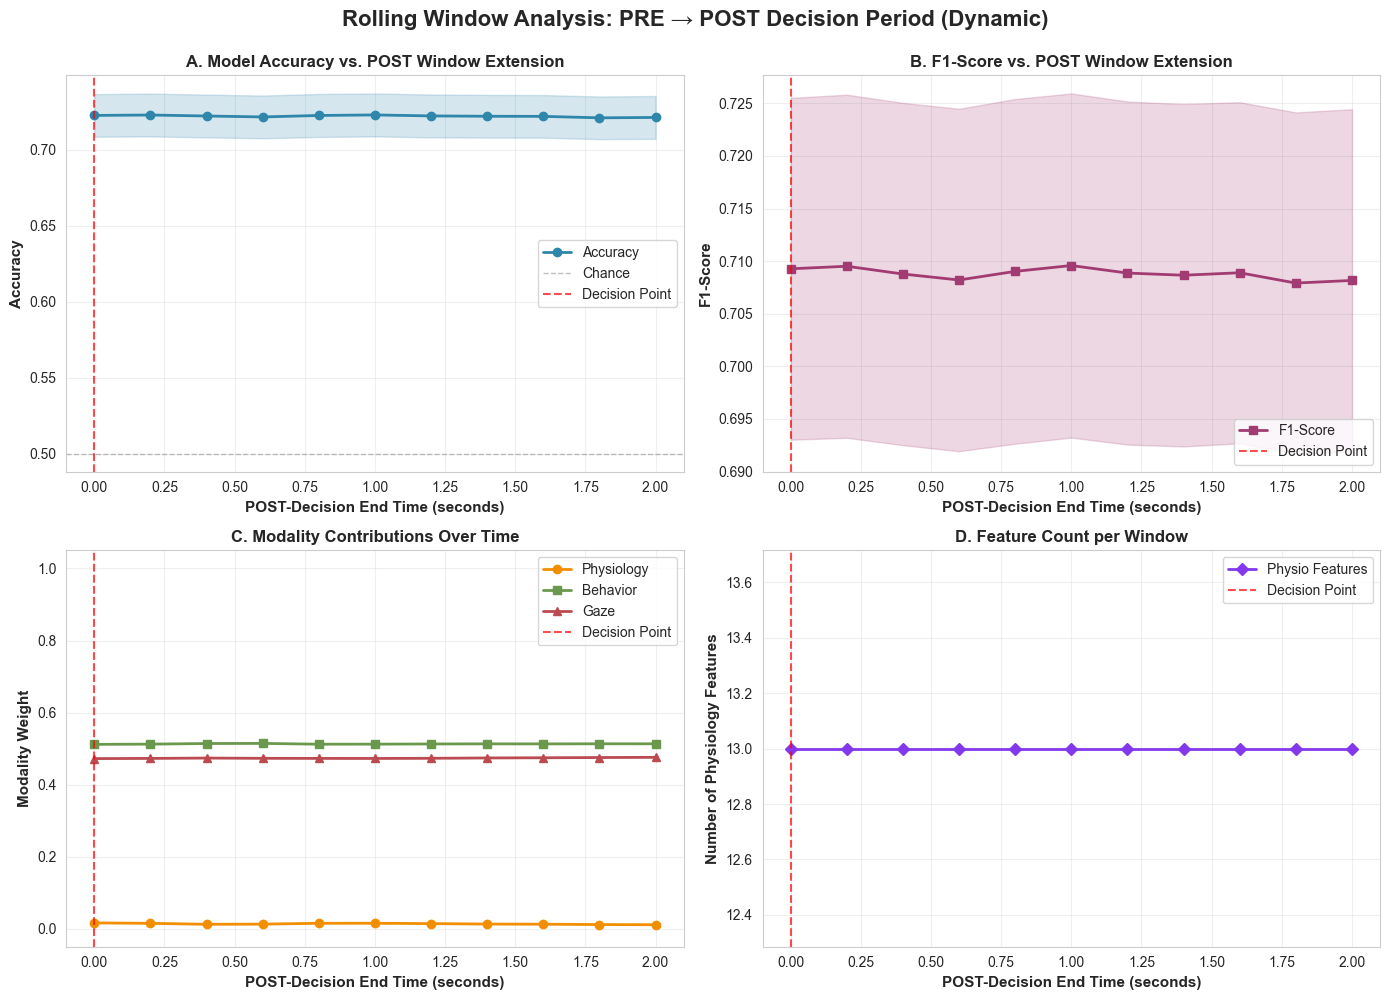


✓ Visualization complete


In [13]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Rolling Window Analysis: PRE → POST Decision Period (Dynamic)', 
             fontsize=16, fontweight='bold', y=0.995)

# Subplot 1: Accuracy over time
ax1 = axes[0, 0]
ax1.plot(results_df['time_end'], results_df['accuracy'], 
         marker='o', linewidth=2, markersize=6, color='#2E86AB', label='Accuracy')
ax1.fill_between(results_df['time_end'],
                  results_df['accuracy'] - results_df['accuracy_sem'],
                  results_df['accuracy'] + results_df['accuracy_sem'],
                  alpha=0.2, color='#2E86AB')
ax1.axhline(y=0.5, color='gray', linestyle='--', linewidth=1, alpha=0.5, label='Chance')
ax1.axvline(x=0.0, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='Decision Point')
ax1.set_xlabel('POST-Decision End Time (seconds)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Accuracy', fontsize=11, fontweight='bold')
ax1.set_title('A. Model Accuracy vs. POST Window Extension', fontsize=12, fontweight='bold')
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)

# Subplot 2: F1-Score over time
ax2 = axes[0, 1]
ax2.plot(results_df['time_end'], results_df['f1_score'], 
         marker='s', linewidth=2, markersize=6, color='#A23B72', label='F1-Score')
ax2.fill_between(results_df['time_end'],
                  results_df['f1_score'] - results_df['f1_sem'],
                  results_df['f1_score'] + results_df['f1_sem'],
                  alpha=0.2, color='#A23B72')
ax2.axvline(x=0.0, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='Decision Point')
ax2.set_xlabel('POST-Decision End Time (seconds)', fontsize=11, fontweight='bold')
ax2.set_ylabel('F1-Score', fontsize=11, fontweight='bold')
ax2.set_title('B. F1-Score vs. POST Window Extension', fontsize=12, fontweight='bold')
ax2.legend(loc='best')
ax2.grid(True, alpha=0.3)

# Subplot 3: Modality weights over time
ax3 = axes[1, 0]
ax3.plot(results_df['time_end'], results_df['physio_weight'], 
         marker='o', linewidth=2, markersize=6, label='Physiology', color='#F18F01')
ax3.plot(results_df['time_end'], results_df['behavior_weight'], 
         marker='s', linewidth=2, markersize=6, label='Behavior', color='#6A994E')
ax3.plot(results_df['time_end'], results_df['gaze_weight'], 
         marker='^', linewidth=2, markersize=6, label='Gaze', color='#BC4B51')
ax3.axvline(x=0.0, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='Decision Point')
ax3.set_xlabel('POST-Decision End Time (seconds)', fontsize=11, fontweight='bold')
ax3.set_ylabel('Modality Weight', fontsize=11, fontweight='bold')
ax3.set_title('C. Modality Contributions Over Time', fontsize=12, fontweight='bold')
ax3.legend(loc='best')
ax3.grid(True, alpha=0.3)
ax3.set_ylim([-0.05, 1.05])

# Subplot 4: Number of physio features over time
ax4 = axes[1, 1]
ax4.plot(results_df['time_end'], results_df['n_physio_features'], 
         marker='D', linewidth=2, markersize=6, color='#8338EC', label='Physio Features')
ax4.axvline(x=0.0, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='Decision Point')
ax4.set_xlabel('POST-Decision End Time (seconds)', fontsize=11, fontweight='bold')
ax4.set_ylabel('Number of Physiology Features', fontsize=11, fontweight='bold')
ax4.set_title('D. Feature Count per Window', fontsize=12, fontweight='bold')
ax4.legend(loc='best')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Visualization complete")

## 6. Statistical Analysis

In [ ]:
print(f"\n{'='*80}")
print("STATISTICAL ANALYSIS")
print(f"{'='*80}\n")

# Compare PRE-only vs. best POST window
pre_only_acc = results_df.iloc[0]['accuracy']
pre_only_sem = results_df.iloc[0]['accuracy_sem']

best_idx = results_df['accuracy'].idxmax()
best_window = results_df.iloc[best_idx]

print("1. PRE-only vs. Best POST Window:")
print(f"   PRE-only:      Accuracy = {pre_only_acc:.4f} ± {pre_only_sem:.4f}")
print(f"   Best window:   {best_window['window_name']}")
print(f"                  Accuracy = {best_window['accuracy']:.4f} ± {best_window['accuracy_sem']:.4f}")
print(f"   Improvement:   {(best_window['accuracy'] - pre_only_acc):.4f} ({100*(best_window['accuracy'] - pre_only_acc)/pre_only_acc:.2f}%)")

# Trend analysis
if len(results_df) > 2:
    post_times = results_df['post_end_time'].values[1:]
    post_accs = results_df['accuracy'].values[1:]
    
    from scipy.stats import pearsonr
    r, p = pearsonr(post_times, post_accs)
    
    print(f"\n2. Trend Analysis (POST windows):")
    print(f"   Pearson r = {r:.4f}, p = {p:.4f}")
    if p < 0.05:
        trend = "positive" if r > 0 else "negative"
        print(f"   ✓ Significant {trend} trend detected")
    else:
        print(f"   ✗ No significant trend")

print(f"\n3. Summary:")
print(f"   Accuracy range: {results_df['accuracy'].min():.4f} to {results_df['accuracy'].max():.4f}")
print(f"   Variability: {results_df['accuracy'].std():.4f}")
print(f"\n{'='*80}")

## 7. Save Results

In [ ]:
output_dir = Path('../../data/results/analysis_outputs_PRE')
output_dir.mkdir(parents=True, exist_ok=True)

output_file = output_dir / 'rolling_window_post_decision_dynamic.csv'
save_results(results_df, str(output_file))

print(f"\n✓ Results saved to: {output_file}")
print(f"\n{'='*80}")
print(f"ANALYSIS COMPLETE")
print(f"{'='*80}")
print(f"Finished: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")